# Weak lensing in harmonic space

This example computes a shear catalogue from a set of matter shells. The computation is carried out in harmonic space.

## Setup

Simulate the matter fields, and use them to iteratively compute the lensing fields.

In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology.compat.camb import Cosmology

# almost all GLASS functionality is available from the `glass` namespace
import glass
import glass.ext.camb

# creating a numpy random number generator for sampling
rng = np.random.default_rng(seed=42)

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 256

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)
results = camb.get_background(pars)

# get the cosmology from CAMB
cosmo = Cosmology(results)

# shells of 200 Mpc in comoving distance spacing
zb = glass.distance_grid(cosmo, 0.0, 1.0, dx=200.0)

# linear radial window functions
shells = glass.linear_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.ext.camb.matter_cls(pars, lmax, shells)

# apply discretisation to the full set of spectra:
# - maximum angular mode number (`lmax=lmax`)
# - number of correlated shells (`ncorr=3`)
cls = glass.discretized_cls(cls, lmax=lmax, ncorr=3)

## Matter

In [ ]:
# set up lognormal fields for simulation
fields = glass.lognormal_fields(shells)

# compute Gaussian spectra for lognormal fields from discretised spectra
gls = glass.solve_gaussian_spectra(fields, cls)

# generator for lognormal matter fields
matter = glass.generate(fields, gls, nside, ncorr=3, rng=rng)

## Lensing

In [ ]:
# this will compute the convergence field iteratively
convergence = glass.MultiPlaneConvergence(cosmo)

## Galaxies

In [ ]:
# localised redshift distribution
# normalised to 0.01 galaxies/arcmin2
z = np.linspace(0.0, 1.0, 101)
dndz = np.exp(-((z - 0.5) ** 2) / (0.1) ** 2)
dndz = 0.1 * dndz / np.trapezoid(dndz, z)

# distribute dN/dz over the radial window functions
ngal = glass.partition(z, dndz, shells)

## Simulation

The simulation is carried out in harmonic space: the spherical harmonic decomposition of `delta` is computed on the fly. The convergence `kappa` is computed in harmonic space (i.e. $\kappa_{lm}$) as well. The shear values for a set of galaxies are evaluated from the spherical harmonic decomposition.

In [ ]:
# the integrated complex shear field over the redshift distribution
count = np.zeros(12 * nside**2, int)
gamma = np.zeros(12 * nside**2, complex)

# main loop to simulate the matter fields iteratively
# delta is converted to harmonic space on the fly
for i, delta in enumerate(glass.harmonic_space(matter)):
    # add lensing plane from the window function of this shell
    convergence.add_window(delta, shells[i])

    # get convergence field (in harmonic space!)
    kappa = convergence.kappa

    # get random positions on the sphere
    for lon, lat, _ in glass.uniform_positions(ngal[i], rng=rng):
        # compute gamma in sampled positions from
        # the spherical harmonic decomposition of kappa
        gamma_gal = glass.harmonic_shear(kappa, lon, lat)

        # add to integrated map
        ipix = hp.ang2pix(nside, lon, lat, lonlat=True)
        np.add.at(count, ipix, 1)
        np.add.at(gamma, ipix, gamma_gal)

# average shear map
gamma[count > 0] /= count[count > 0]

## Analysis

To make sure the simulation works, compute the angular power spectrum of the simulated convergence field, and compare with the expectation (from CAMB) for the given redshift distribution of sources.

We are not doing the modelling very carefully here, so a bit of discrepancy is to be expected.

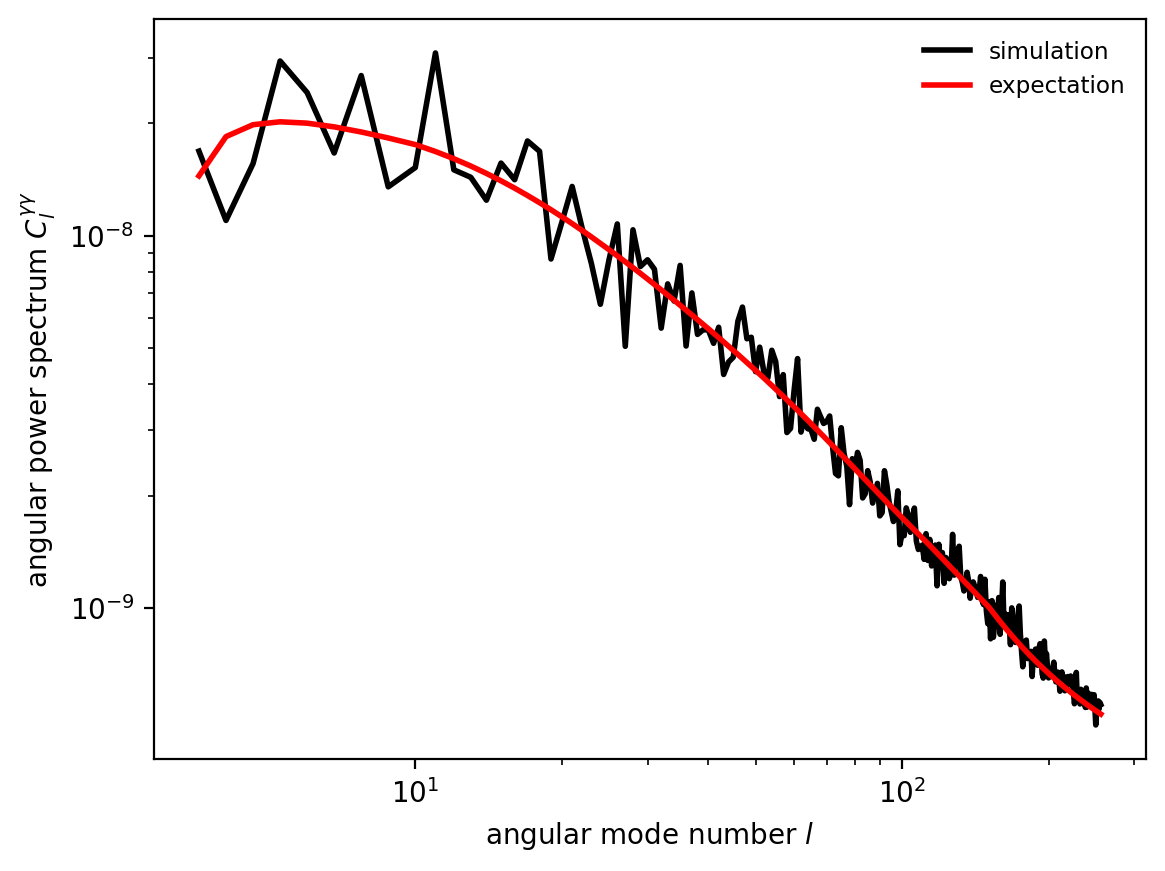

In [ ]:
# get the angular power spectra of the lensing maps
sim_cls = hp.anafast(
    [count, gamma.real, gamma.imag],
    pol=True,
    lmax=lmax,
    use_pixel_weights=True,
)

# get the expected cls from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type="lensing"),
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

# get the HEALPix pixel window function, since the lensing fields have it
pw0, pw2 = hp.pixwin(nside, lmax=lmax, pol=True)

# plot the realised and expected cls
ell = np.arange(2, lmax + 1)
fl = ((ell + 2) * (ell - 1)) / (ell * (ell + 1)) * pw2[2:] ** 2
plt.plot(ell, sim_cls[1][2:], "-k", lw=2, label="simulation")
plt.plot(ell, fl * theory_cls["W1xW1"][2:], "-r", lw=2, label="expectation")
plt.xscale("symlog", linthresh=10, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yscale("symlog", linthresh=1e-9, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel(r"angular mode number $l$")
plt.ylabel(r"angular power spectrum $C_l^{\gamma\gamma}$")
plt.legend(frameon=False)
plt.show()